# **Ensemble Learning and Random Forests**

Suppose you pose a complex question to thousands of random people,
then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom
of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is
called an ensemble; thus, this technique is called ensemble learning, and
an ensemble learning algorithm is called an ensemble method.

As an example of an ensemble method, you can train a group of decision
tree classifiers, each on a different random subset of the training set. You
can then obtain the predictions of all the individual trees, and the class
that gets the most votes is the ensemble’s prediction. Such an ensemble of decision trees is called a random forest, and despite its simplicity, this is one of the most powerful machine
learning algorithms available today.

You will often use ensemble methods near the
end of a project, once you have already built a few good predictors, to
combine them into an even better predictor. In fact, the winning solutions in machine learning competitions often involve several ensemble
methods—most famously in the Netflix Prize competition.

In this lesson we will examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, random forests,
and boosting, and stacking ensembles.

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80%
accuracy. You may have a logistic regression classifier, an SVM classifier,
a random forest classifier, a k-nearest neighbors classifier, and perhaps a
few more

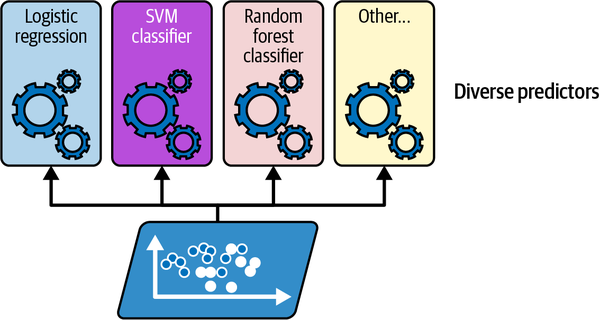

A very simple way to create an even better classifier is to aggregate the
predictions of each classifier: the class that gets the most votes is the
ensemble’s prediction. This majority-vote classifier is called a hard voting
classifier

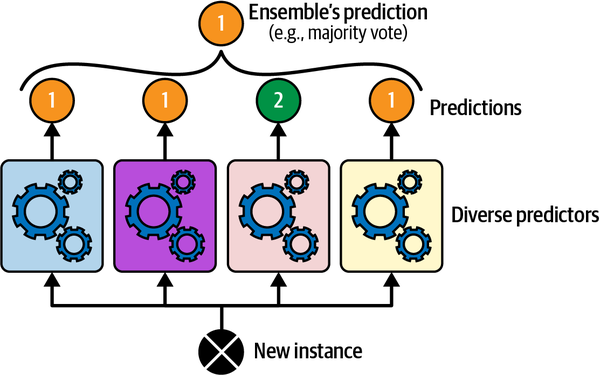

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random
guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on
this mystery. Suppose you have a slightly biased coin that has a 51%
chance of coming up heads and 49% chance of coming up tails. If you toss
it 1,000 times, you will generally get more or less 510 heads and 490 tails,
and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to
75%. The more you toss the coin, the higher the probability (e.g., with
10,000 tosses, the probability climbs over 97%). This is due to the law of
large numbers: as you keep tossing the coin, the ratio of heads gets closer
and closer to the probability of heads (51%). Figure below shows 10 series of
biased coin tosses. You can see that as the number of tosses increases, the
ratio of heads approaches 51%. Eventually all 10 series end up so close to
51% that they are consistently above 50%.

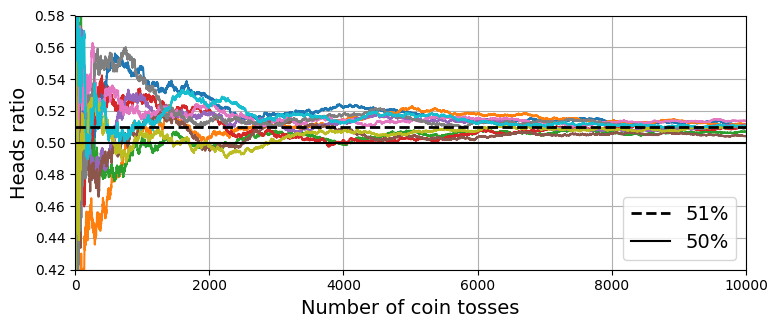

In [ ]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that
are individually correct only 51% of the time (barely better than random
guessing). If you predict the majority voted class, you can hope for up to
75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same
types of errors, so there will be many majority votes for the wrong class,
reducing the ensemble’s accuracy.

**TIP**

Ensemble methods work best when the predictors are as independent from one
another as possible. One way to get diverse classifiers is to train them using very
different algorithms. This increases the chance that they will make very different
types of errors, improving the ensemble’s accuracy.

Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use:
just give it a list of name/predictor pairs, and use it like a normal classifier. Let’s try it on the moons dataset. We will
load and split the moons dataset into a training set and a test set, then
we’ll create and train a voting classifier composed of three diverse
classifiers:

Let's build a voting classifier:

In [ ]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42, probability = True))
    ], voting = "soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

`When you fit a VotingClassifier` , it clones every estimator and fits the
clones. The original estimators are available via the estimators attribute, while the fitted clones are available via the `estimators_` attribute.
If you prefer a dict rather than a list, you can use `named_estimators` or
`named_estimators_` instead. To begin, let’s look at each fitted
classifier’s accuracy on the test set:

In [ ]:
voting_clf.named_estimators_

{'lr': LogisticRegression(random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'svc': SVC(probability=True, random_state=42)}

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


When you call the voting classifier’s `predict()` method, it performs
hard voting. For example, the voting classifier predicts class 1 for the first
instance of the test set, because two out of three classifiers predict that
class:

In [ ]:
voting_clf.predict(X_test[:2])

array([0, 0])

In [ ]:
y_test[:2]

array([1, 1])

In [ ]:
[clf.predict_proba(X_test[:1]) for clf in voting_clf.estimators_]

[array([[0.49899618, 0.50100382]]),
 array([[0.48, 0.52]]),
 array([[0.56982947, 0.43017053]])]

Now let’s look at the performance of the voting classifier on the test set:

In [ ]:
voting_clf.score(X_test, y_test)

0.92

Now let's use **soft voting**:

If all classifiers are able to estimate class probabilities (i.e., if they all have
a `predict_proba()` method), then you can tell Scikit-Learn to predict
the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident
votes. All you need to do is set the voting classifier’s voting hyperparameter to "soft" , and ensure that all classifiers can estimate class
probabilities. This is not the case for the SVC class by default, so you
need to set its probability hyperparameter to True (this will make
the `SVC` class use cross-validation to estimate class probabilities, slowing
down training, and it will add a `predict_proba()` method). Let’s try
that:

In [ ]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting
## Bagging and Pasting in Scikit-Learn

One way to get a diverse set of classifiers is to use very different training
algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor but train them on different random
subsets of the training set. When sampling is performed with
replacement,⁠ this method is called bagging⁠ (short for bootstrap
aggregating⁠). When sampling is performed without replacement, it is
called pasting.⁠

In other words, both bagging and pasting allow training instances to be
sampled several times across multiple predictors, but only bagging allows
training instances to be sampled several times for the same predictor.
This sampling and training process is represented in Picture:

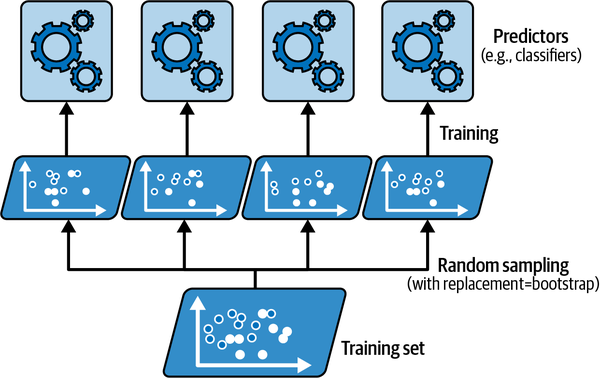

Once all predictors are trained, the ensemble can make a prediction for a
new instance by simply aggregating the predictions of all predictors. The
aggregation function is typically the statistical mode for classification (i.e.,
the most frequent prediction, just like with a hard voting classifier), or
the average for regression. Each individual predictor has a higher bias
than if it were trained on the original training set, but aggregation reduces both bias and variance.⁠ Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained
on the original training set.

As you can see in Figure above, predictors can all be trained in parallel, via
different CPU cores or even different servers. Similarly, predictions can
be made in parallel. This is one of the reasons bagging and pasting are
such popular methods: they scale very well.

**Bagging and Pasting in Scikit-Learn**

Scikit-Learn offers a simple API for both bagging and pasting:
`BaggingClassifier` class (or `BaggingRegressor` for regression). The
following code trains an ensemble of 500 decision tree classifiers:⁠ each is
trained on 100 training instances randomly sampled from the training set
with replacement (this is an example of bagging, but if you want to use
pasting instead, just set `bootstrap=False` ). The `n_jobs` parameter
tells Scikit-Learn the number of CPU cores to use for training and predictions, and `–1` tells Scikit-Learn to use all available cores:

**NOTE**

A `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a
`predict_proba()` method), which is the case with decision tree classifiers.

Figure below compares the decision boundary of a single decision tree with
the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. As you can see, the
ensemble’s predictions will likely generalize much better than the single
decision tree’s predictions: the ensemble has a comparable bias but a
smaller variance (it makes roughly the same number of errors on the
training set, but the decision boundary is less irregular).

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Bagging introduces a bit more diversity in the subsets that each predictor
is trained on, so bagging ends up with a slightly higher bias than pasting;
but the extra diversity also means that the predictors end up being less
correlated, so the ensemble’s variance is reduced. Overall, bagging often
results in better models, which explains why it’s generally preferred. But
if you have spare time and CPU power, you can use cross-validation to
evaluate both bagging and pasting and select the one that works best.

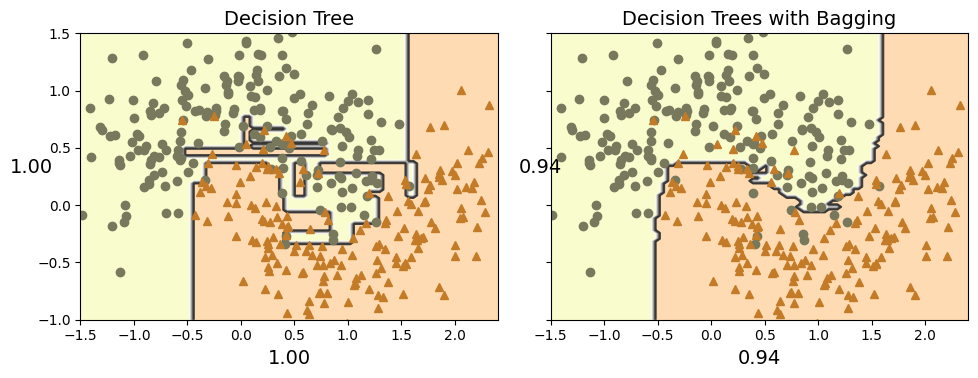

In [ ]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.ylabel(f"{tree_clf.score(X_train, y_train):.2f}")
plt.xlabel(f"{tree_clf.score(X_train, y_train):.2f}")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel(f"{bag_clf.score(X_train, y_train):.2f}")
plt.xlabel(f"{bag_clf.score(X_train, y_train):.2f}")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

With bagging, some training instances may be sampled several times for
any given predictor, while others may not be sampled at all. By default a
`BaggingClassifier` samples m training instances with replacement
( `bootstrap=True` ), where m is the size of the training set. With this
process, it can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor.⁠ The remaining 37% of the training instances that are not sampled are called out-of-bag
(OOB) instances. Note that they are not the same 37% for all predictors.

A bagging ensemble can be evaluated using OOB instances, without the
need for a separate validation set: indeed, if there are enough estimators,
then each instance in the training set will likely be an OOB instance of
several estimators, so these estimators can be used to make a fair ensemble prediction for that instance. Once you have a prediction for each instance, you can compute the ensemble’s prediction accuracy (or any other
metric).

In Scikit-Learn, you can set `oob_score=True` when creating a
`BaggingClassifier` to request an automatic OOB evaluation after
training. The following code demonstrates this. The resulting evaluation
score is available in the `oob_score_` attribute:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42, bootstrap = True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to this OOB evaluation, this `BaggingClassifier` is likely to
achieve about 89.6% accuracy on the test set. Let’s verify this:

In [ ]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We get 92% accuracy on the test. The OOB evaluation was a bit too pessimistic, just over 2% too low.

The OOB decision function for each training instance is also available
through the `oob_decision_function_` attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the
class probabilities for each training instance. For example, the OOB evalu-
ation estimates that the first training instance has a 67.6% probability of
belonging to the positive class and a 32.4% probability of belonging to the
negative class:

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [ ]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# **Random Patches and Random Subspaces**

`The BaggingClassifier` class supports sampling the features as well.
Sampling is controlled by two hyperparameters: `max_features` and
`bootstrap_features` . They work the same way as `max_samples` and
*bootstrap* , but for feature sampling instead of instance sampling. Thus,
each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images), as it can considerably speed up training. Sampling both training instances and features is called the random
patches method.⁠ Keeping all training instances (by setting
`bootstrap=False` and `max_samples=1.0` ) but sampling features (by
setting `bootstrap_features` to `True` and/or `max_features` to a
value smaller than `1.0` ) is called the random subspaces method.⁠

Sampling features results in even more predictor diversity, trading a bit
more bias for a lower variance.

# **Random Forests**

As we have discussed, a random forest⁠ is an ensemble of decision trees,
generally trained via the bagging method (or sometimes pasting), typi-
cally with `max_samples` set to the size of the training set. Instead of
building a `BaggingClassifier` and passing it a
`DecisionTreeClassifier` , you can use the
`RandomForestClassifier` class, which is more convenient and optimized for decision trees⁠ (similarly, there is a
`RandomForestRegressor` class for regression tasks). The following code
trains a random forest classifier with 500 trees, each limited to maximum
16 leaf nodes, using all available CPU cores:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are
grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing
trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of
features. By default, it samples `sqrt(n)`
features (where n is the total number
of features). The algorithm results in greater tree diversity, which (again)
trades a higher bias for a lower variance, generally yielding an overall
better model. So, the following `BaggingClassifier` is equivalent to the
previous `RandomForestClassifier` :

A Random Forest is equivalent to a bag of decision trees:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [ ]:
y_pred_bag

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
y_pred_bag == y_pred_rf

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
np.all(y_pred_bag == y_pred_rf)

True

# **Extra-Trees**

When you are growing a tree in a random forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random
thresholds for each feature rather than searching for the best possible
thresholds (like regular decision trees do). For this, simply set
`splitter="random"` when creating a `DecisionTreeClassifier` .

A forest of such extremely random trees is called an *extremely randomized trees⁠* (or extra-trees for short) ensemble. Once again, this technique
trades more bias for a lower variance. It also makes extra-trees classifiers
much faster to train than regular random forests, because finding the
best possible threshold for each feature at every node is one of the most
time-consuming tasks of growing a tree.

You can create an extra-trees classifier using Scikit-Learn’s
`ExtraTreesClassifier` class. Its API is identical to the
`RandomForestClassifier` class, except `bootstrap` defaults to
False . Similarly, the `ExtraTreesRegressor` class has the same API as
the `RandomForestRegressor` class, except `bootstrap` defaults to
`False` .

**TIP**

It is hard to tell in advance whether a `RandomForestClassifier` will perform
better or worse than an `ExtraTreesClassifier` . Generally, the only way to
know is to try both and compare them using cross-validation.

## **Feature Importance**

Yet another great quality of random forests is that they make it easy to
measure the relative importance of each feature. Scikit-Learn measures a
feature’s importance by looking at how much the tree nodes that use that
feature reduce impurity on average, across all trees in the forest. More
precisely, it is a weighted average, where each node’s weight is equal to
the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after
training, then it scales the results so that the sum of all importances is
equal to 1. You can access the result using the `feature_importances_`
variable. For example, the following code trains `RandomForestClassifier` on the iris dataset and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length
and width are rather unimportant in comparison (11% and 2%,
respectively):

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


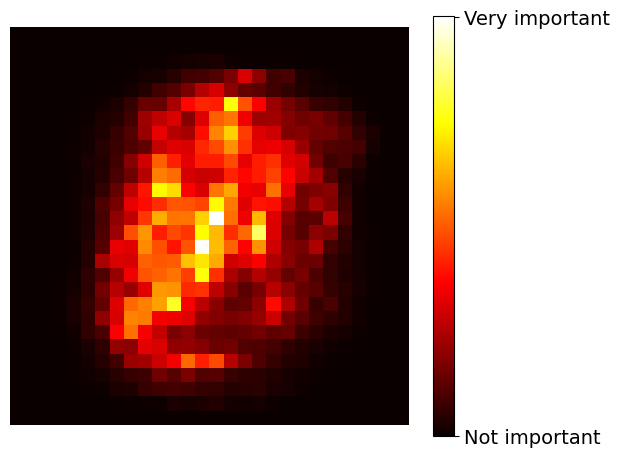

In [ ]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Similarly, if you train a random forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in Figure above.

Random forests are very handy to get a quick understanding of what fea-
tures actually matter, in particular if you need to perform feature
selection.

# **Boosting**

`Boosting` (originally called hypothesis boosting) refers to any ensemble
method that can combine several weak learners into a strong learner.
The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting
methods available, but by far the most popular are `AdaBoost⁠` (short for
`adaptive boosting`) and gradient boosting. Let’s start with `AdaBoost`.

## **AdaBoost**

One way for a new predictor to correct its predecessor is to pay a bit
more attention to the training instances that the predecessor underfit.
This results in new predictors focusing more and more on the hard cases.
This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first
trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight
of misclassified training instances. Then it trains a second classifier, using
the updated weights, and again makes predictions on the training set, updates the instance weights, and so on

This figure shows the decision boundaries of five consecutive predictors
on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel).⁠ The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right
represents the same sequence of predictors, except that the learning rate
is halved (i.e., the misclassified instance weights are boosted much less at
every iteration). As you can see, this sequential learning technique has
some similarities with gradient descent, except that instead of tweaking a
single predictor’s parameters to minimize a cost function, AdaBoost adds
predictors to the ensemble, gradually making it better.

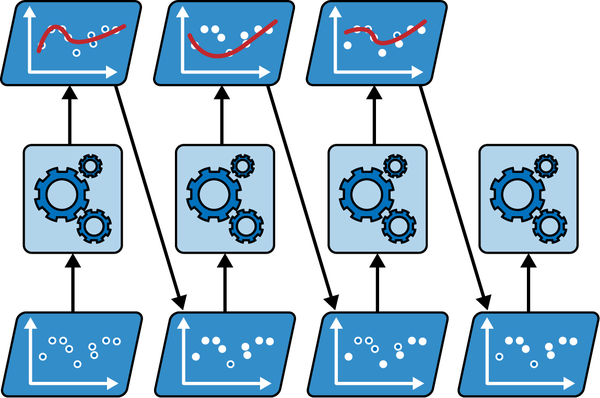

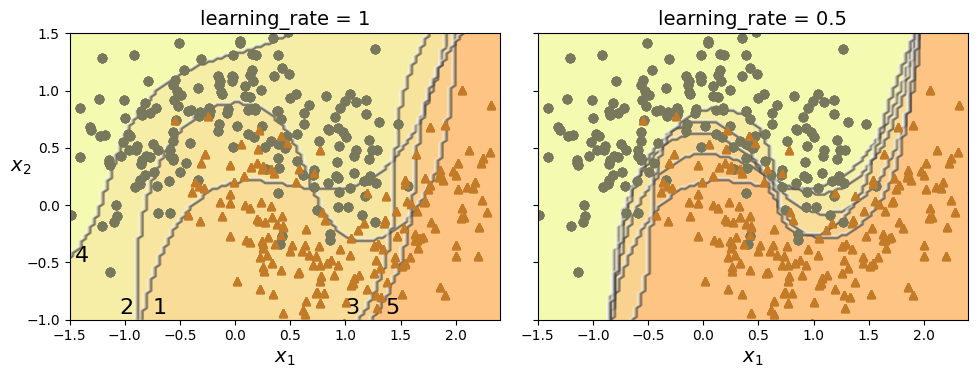

In [ ]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

Once all predictors are trained, the ensemble makes predictions very
much like bagging or pasting, except that predictors have different
weights depending on their overall accuracy on the weighted training set.

**W A R N I N G**


There is one important drawback to this sequential learning technique: training
cannot be parallelized since each predictor can only be trained after the previous
predictor has been trained and evaluated. As a result, it does not scale as well as
bagging or pasting.

In [ ]:
ada_clf.score(X_test, y_test)

0.904

The following code trains an AdaBoost classifier based on 30 decision
stumps using Scikit-Learn’s AdaBoostClassifier class (as you might
expect, there is also an AdaBoostRegressor class). A decision stump is a
decision tree with max_depth=1 —in other words, a tree composed of a
single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

**TIP**

If your AdaBoost ensemble is overfitting the training set, you can try reducing the
number of estimators or more strongly regularizing the base estimator.

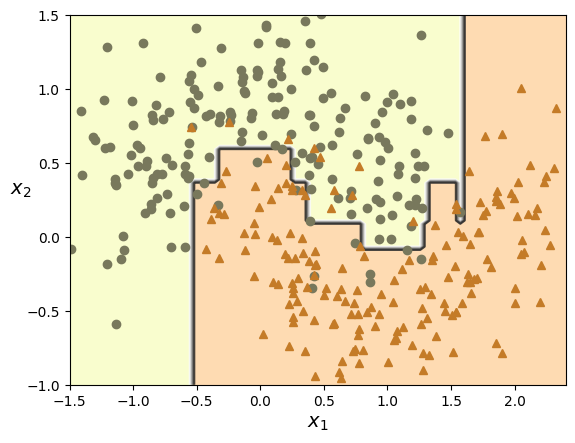

In [ ]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## **Gradient Boosting**

Another very popular boosting algorithm is **gradient boosting**.⁠ Just like
AdaBoost, gradient boosting works by sequentially adding predictors to
an ensemble, each one correcting its predecessor. However, instead of
tweaking the instance weights at every iteration like AdaBoost does, this
method tries to fit the new predictor to the *residual errors* made by the
previous predictor.

Let’s go through a simple regression example, using decision trees as the
base predictors; this is called `gradient tree boosting`, or `gradient boosted regression trees` (GBRT). First, let’s generate a noisy quadratic dataset and
fit a `DecisionTreeRegressor` to it:

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now let's train another decision tree regressor on the residual errors made by the previous predictor:

In [ ]:
y

array([ 5.15728987e-02,  5.94479790e-01,  1.66051606e-01, -7.01779562e-02,
        3.43985933e-01,  3.72874939e-01,  6.59764984e-01,  3.76341398e-01,
       -9.75194335e-03,  1.04794741e-01,  7.35287787e-01,  6.78883363e-01,
        3.05066318e-01,  2.73909733e-01,  3.08559932e-01,  3.49130363e-01,
        7.98606436e-02, -1.45444646e-02, -5.71096619e-03,  5.75800683e-02,
        5.23392240e-02,  4.02946793e-01,  1.29867214e-01,  4.18481141e-02,
       -6.49789982e-02,  2.22943721e-01,  2.53451786e-01, -3.95060058e-02,
        1.75570720e-02,  6.37324227e-01,  1.29006981e-01,  3.34391950e-01,
        5.80417870e-01,  6.00772381e-01,  5.54501010e-01,  2.84001079e-01,
        1.17538848e-01,  6.08765289e-01,  9.22073759e-02,  2.58225391e-02,
        4.26829699e-01, -5.83641153e-02,  7.07523289e-01,  5.40226226e-01,
        2.14112889e-01,  3.37711060e-02,  1.76497872e-01, -6.88843767e-02,
        3.58884053e-02,  4.07472924e-01,  6.12002352e-01,  1.98779325e-01,
        5.84460527e-01,  

In [ ]:
tree_reg1.predict(X)

array([0.12356613, 0.52856846, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.66091233, 0.52856846, 0.12356613, 0.12356613,
       0.66091233, 0.52856846, 0.52856846, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.48779682, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.66091233,
       0.12356613, 0.12356613, 0.66091233, 0.52856846, 0.52856846,
       0.12356613, 0.12356613, 0.48779682, 0.12356613, 0.12356613,
       0.48779682, 0.12356613, 0.66091233, 0.52856846, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.12356613,
       0.52856846, 0.12356613, 0.52856846, 0.52856846, 0.12356613,
       0.52856846, 0.48779682, 0.12356613, 0.66091233, 0.12356613,
       0.12356613, 0.12356613, 0.52856846, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.48779682, 0.52856846,
       0.12356613, 0.12356613, 0.66091233, 0.12356613, 0.12356

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [ ]:
y2

array([-0.07199323,  0.06591133,  0.04248548, -0.19374408,  0.22041981,
        0.24930881, -0.00114735, -0.15222706, -0.13331807, -0.01877138,
        0.07437546,  0.1503149 , -0.22350214,  0.15034361,  0.18499381,
        0.22556424, -0.04370548, -0.13811059, -0.12927709, -0.06598606,
       -0.0712269 , -0.08485003,  0.00630109, -0.08171801, -0.18854512,
        0.0993776 ,  0.12988566, -0.16307213, -0.10600905, -0.0235881 ,
        0.00544086,  0.21082582, -0.08049446,  0.07220392,  0.02593255,
        0.16043495, -0.00602728,  0.12096847, -0.03135875, -0.09774359,
       -0.06096712, -0.18193024,  0.04661096,  0.01165776,  0.09054676,
       -0.08979502,  0.05293175, -0.1924505 , -0.08767772,  0.2839068 ,
        0.08343389,  0.0752132 ,  0.05589207, -0.08607633, -0.17234608,
        0.0087933 , -0.03289674,  0.17739276, -0.08642889,  0.04545908,
       -0.12555055,  0.01717459, -0.16368755, -0.12355051,  0.03177594,
       -0.05274012,  0.18286595,  0.15963461,  0.06821878,  0.22

And then we’ll train a third regressor on the residual errors made by the
second predictor:

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we have an ensemble containing three trees. It can make predictions
on a new instance simply by adding up the predictions of all the trees:

In [ ]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

Figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row,
the ensemble has just one tree, so its predictions are exactly the same as
the first tree’s predictions. In the second row, a new tree is trained on the
residual errors of the first tree. On the right you can see that the
ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions
gradually get better as trees are added to the ensemble.

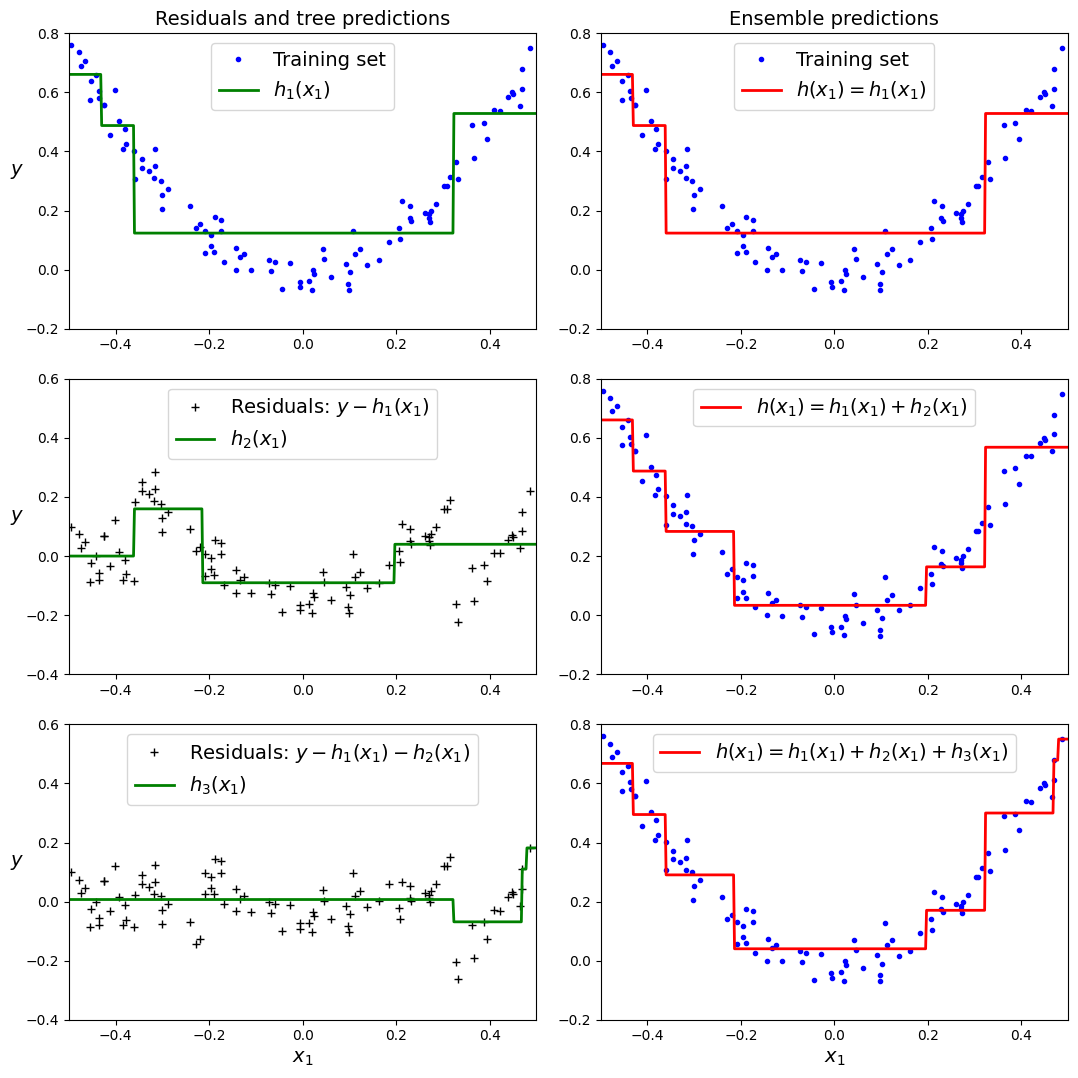

In [ ]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

You can use Scikit-Learn’s `GradientBoostingRegressor` class to train
GBRT ensembles more easily (there’s also a
`GradientBoostingClassifier` class for classification). Much like the
`RandomForestRegressor` class, it has hyperparameters to control the
growth of decision trees (e.g., `max_depth` , `min_samples_leaf` ), as well
as hyperparameters to control the ensemble training, such as the number
of trees ( `n_estimators` ). The following code creates the same ensemble
as the previous one:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

To find the optimal number of trees, you could perform cross-validation
using `GridSearchCV` or `RandomizedSearchCV` , as usual, but there’s a
simpler way: if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the `GradientBoostingRegressor` will auto-
matically stop adding more trees during training if it sees that the last 10
trees didn’t help. This is simply early stopping,
but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. Let’s train the ensemble using early stopping:

In [ ]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=15, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=15, random_state=42)

In [ ]:
gbrt_best.n_estimators_

97

The learning_rate hyperparameter scales the contribution of each
tree. If you set it to a low value, such as 0.05 , you will need more trees
in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage.
Figure below shows two GBRT ensembles trained with different hyperparameters: the one on the left does not have enough trees to fit the training
set, while the one on the right has about the right amount. If we added
more trees, the GBRT would start to overfit the training set.

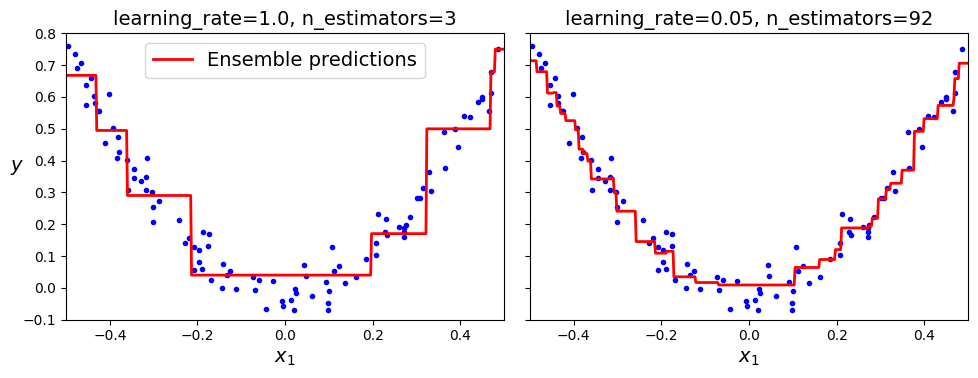

In [ ]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

In [ ]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [ ]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

# Stacking

The last ensemble method we will discuss in this lesson is called **stacking** (short for stacked generalization).⁠ It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to
perform this aggregation? Figure below shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a `blender`, or a `meta learner`) takes these predictions as inputs
and makes the final prediction (3.0).

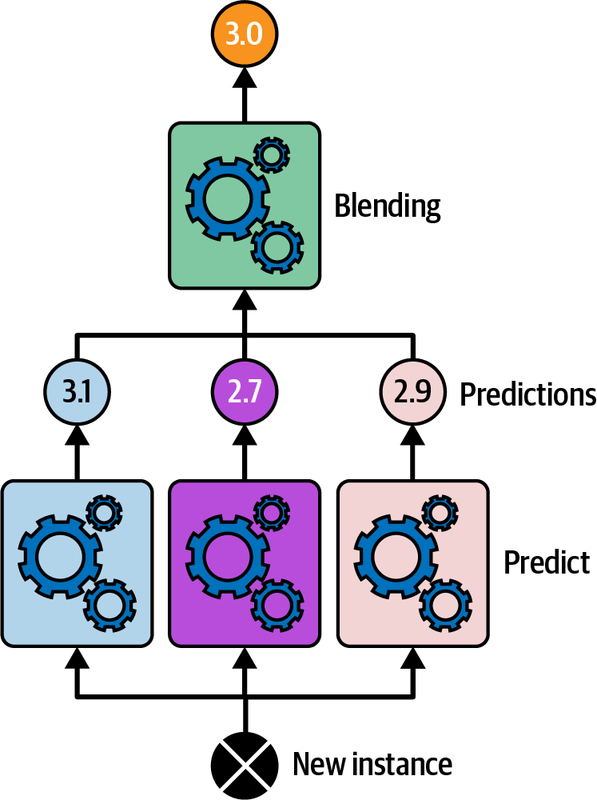

To train the blender, you first need to build the blending training set. You
can use `cross_val_predict()` on every predictor in the ensemble to
get out-of-sample predictions for each instance in the original training set
(Figure below), and use these can be used as the input features to train the
blender; and the targets can simply be copied from the original training
set. Note that regardless of the number of features in the original training
set (just one in this example), the blending training set will contain one
input feature per predictor (three in this example). Once the blender is
trained, the base predictors are retrained one last time on the full original
training set.

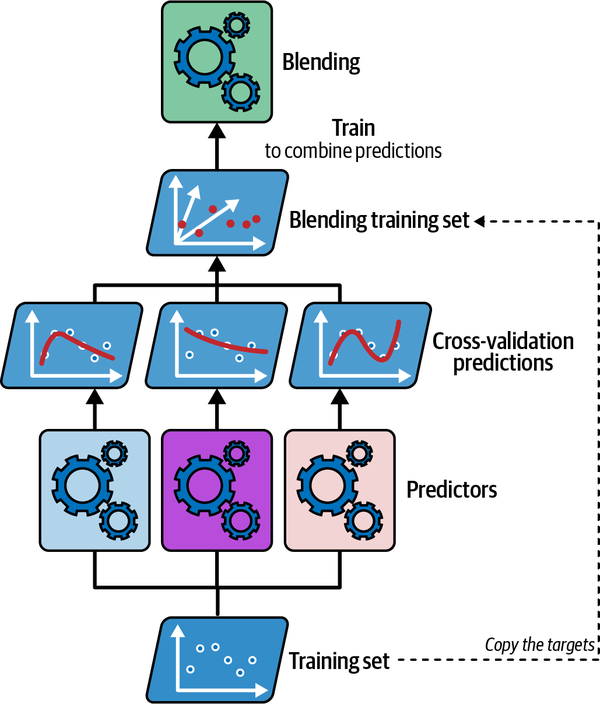

It is actually possible to train several different blenders this way (e.g., one
using linear regression, another using random forest regression) to get a
whole layer of blenders, and then add another blender on top of that to
produce the final prediction, as shown in Figure below. You may be able to
squeeze out a few more drops of performance by doing this, but it will
cost you in both training time and system complexity.

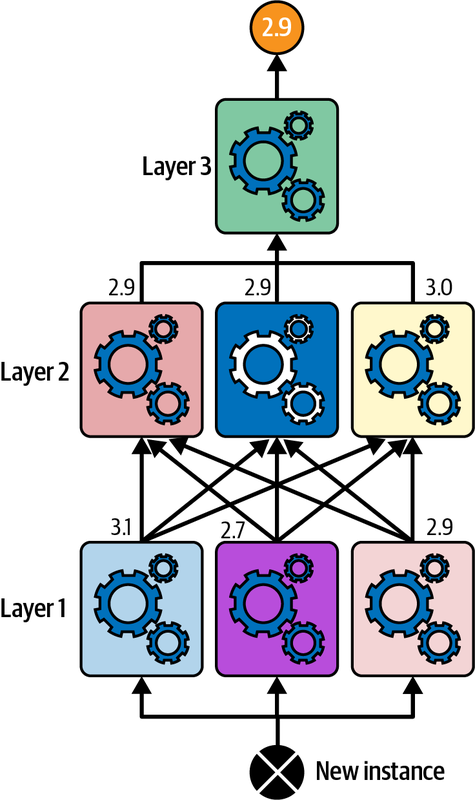

Scikit-Learn provides two classes for stacking ensembles:
`StackingClassifier` and StackingRegressor . For example, we can
replace the `VotingClassifier` we used at the beginning of this chapter
on the moons dataset with a `StackingClassifier` :

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

For each predictor, the stacking classifier will call `predict_proba()` if
available; if not it will fall back to `decision_function()` or, as a last
resort, call `predict()` . If you don’t provide a final estimator,
`StackingClassifier` will use `LogisticRegression` and
`StackingRegressor` will use `RidgeCV` .

In [ ]:
stacking_clf.score(X_test, y_test)

0.928

If you evaluate this stacking model on the test set, you will find 92.8% accuracy, which is a bit better than the voting classifier using soft voting,
which got 92%.

In conclusion, ensemble methods are versatile, powerful, and fairly sim-
ple to use. `Random forests`, `AdaBoost`, and `GBRT` are among the first models you should test for most machine learning tasks, and they particularly
shine with heterogeneous tabular data. Moreover, as they require very
little preprocessing, they’re great for getting a prototype up and running
quickly. Lastly, ensemble methods like voting classifiers and stacking clas-
sifiers can help push your system’s performance to its limits.

# Exercise solutions

## 1. to 7.

1. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.
2. A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).
3. It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.
4. With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.
5. When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don't search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.
6. If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.
7. If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier. The dataset is already split into a training set (the first 60,000 instances) and a test set (the last 10,000 instances), and the training set is already shuffled. So all we need to do is to take the first 50,000 instances for the new training set, the next 10,000 for the validation set, and the last 10,000 for the test set:

In [ ]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Note: The `LinearSVC` has a `dual` hyperparameter whose default value will change from `True` to `"auto"` in Scikit-Learn 1.5. To ensure this notebook continues to produce the same outputs, I'm setting it explicitly to `True`. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for more details.

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine \[the classifiers\] into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_valid, y_valid)

The `VotingClassifier` made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a `LabelEncoder`:

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [ ]:
y_valid_encoded = y_valid.astype(np.int64)

Now let's evaluate the classifier clones:

In [ ]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `"drop"` using `set_params()` like this:

In [ ]:
voting_clf.set_params(svm_clf="drop")

This updated the list of estimators:

In [ ]:
voting_clf.estimators

However, it did not update the list of _trained_ estimators:

In [ ]:
voting_clf.estimators_

In [ ]:
voting_clf.named_estimators_

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators, both in `estimators_` and `named_estimators_`:

In [ ]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

Now let's evaluate the `VotingClassifier` again:

In [ ]:
voting_clf.score(X_valid, y_valid)

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_valid, y_valid)

Nope, hard voting wins in this case.

_Once you have found \[an ensemble that performs better than the individual predictors\], try it on the test set. How much better does it perform compared to the individual classifiers?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

The voting classifier reduced the error rate of the best model from about 3% to 2.7%, which means 10% less errors.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [ ]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [ ]:
X_valid_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

In [ ]:
rnd_forest_blender.oob_score_

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
accuracy_score(y_test, y_pred)

This stacking ensemble does not perform as well as the voting classifier we trained earlier.

Exercise: _Now try again using a `StackingClassifier` instead: do you get better performance? If so, why?_

Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [ ]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Now let's create and train the stacking classifier on the full training set:

**Warning**: the following cell will take quite a while to run (15-30 minutes depending on your hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [ ]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

In [ ]:
stack_clf.score(X_test, y_test)

The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:

* Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
* It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.

And that's all for today, congratulations on finishing the chapter and the exercises!